https://www.davidsilver.uk/wp-content/uploads/2020/03/pg.pdf

https://github.com/CLAIR-LAB-TECHNION/FSTMA-course/blob/main/tutorials/tut04/Policy_Gradient.ipynb

https://github.com/CLAIR-LAB-TECHNION/FSTMA-course/blob/main/tutorials/tut06/Actor%20Critic.ipynb

https://medium.com/@thechrisyoon/deriving-policy-gradients-and-implementing-reinforce-f887949bd63

https://gymnasium.farama.org/environments/classic_control/pendulum/

# Policy Gradient

## The Environment For This Tuturial
In this tutorial we are going to work on the gymnasium Pendulum envrionment: https://gymnasium.farama.org/environments/classic_control/pendulum/

<img src="assets/pendulum.gif" style="height:200px">

In this envrionment, the agents goal is to level the pendulum so it will face up, and keep it there.

The agents obseves 3 dimensional vector of the pendulum free end position (x,y) and it's angular velocity:

<img src="assets/pendulum_state.png" style="height:150px">

It's action is one element, which is what toque (force) to apply on the pendulum.

<img src="assets/pendulum_action.png" style="height:70px">

And the reward function is negative (penalty) for how far the pendulum is from being up, for it's angular velocity, and for the torque the agent applies. 
The reward in each time step can be between -16.27 to 0. 

<img src="assets/pendulum_reward.png" style="height:35px">

At each episode, the pendulum starts at a random state, and the agent plays for a fixed number of steps $T=200$


#### <img src="https://em-content.zobj.net/thumbs/240/apple/354/party-popper_1f389.png" style="height:30px"> Code Time
Let's install, create and run the envrionment once with random actions.

In [1]:
! pip install gymnasium

You should consider upgrading via the 'C:\Study\col_ai\pg_tutorial\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
import gymnasium as gym
%matplotlib inline

# for simplicity and time saving, we will make our environment easier by reducing gravity
gravity = 2.0
env = gym.make("Pendulum-v1", render_mode="rgb_array", g=gravity)

Ran for 200 time steps and accumulated -483.8947128395646 reward



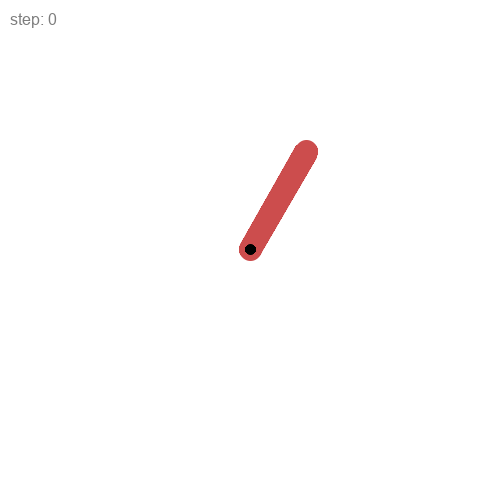

In [3]:
from utils import plot_video

# run one episode with random actions:
terminated, truncated = False, False
total_reward = 0.0
time_steps = 0
images = []
observation, info = env.reset()
while not terminated and not truncated:
    images.append(env.render())
    action = env.observation_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    time_steps += 1

print(f"Ran for {time_steps} time steps and accumulated {total_reward} reward")
plot_video(images)

## Policy Based Methods
We have seen that Q learning is not scalable to high dimensional state space, thus we use function approximation methods (such as neural networks) to estimate our Q function. But we still have to output the value of each action, what if we have continuous or too many possible actions? we will meet the course of dimensionality.

In this tutorial we are going to present a different approach: **Policy Based Methods** and specifically **Policy Gradient Methods**.
Instead of learning the Q function, we will learn a **parameterized policy** $\pi_{\theta}(s) = \pi(s;\theta)$ where $\theta$ is a set of learnable parameters and $\pi$ is a distribution function over all possible actions.

<img src="assets/policy_vs_value.png" style="height:350px">

#### Advantages of Policy based RL
* Better convergence properties
* Large and continuous action spaces
* Stochastic policies

#### Disadvantages
* Converges to local minima
* High variance (unless combined with Value-Based)

*TODO optional: explain why stochastic policy is better.*

## Parameterized Policy
A parametrized policy can be any function with parameters, that has an input of a state, outputs a distribution function over actions, and it has learnable parameters. One representation of a parametric function is a neural network. If you don't know neural network don't worry about it. All you have to know is that it is a function approximator with learnable parameters we will call $\theta$.

#### <img src="https://em-content.zobj.net/thumbs/240/apple/354/party-popper_1f389.png" style="height:30px"> Code Time
We have provided you with an implemntation of such policy, which is a neural network. As mentioned earlier, you don't need to know how it's implemented, what it does. and how to access it's parameters.
We will initialize a policy with input size of our state space and output of our action space. 
This is a stochastic policy! It doesn't output an action, but a distribution function over actions. In this policy, the action distribution is modeled as a gaussian distribution, and the policy outputs the mean and variance of the gaussian. 

action mean: [-0.2868858]; action variance: [0.6109199]


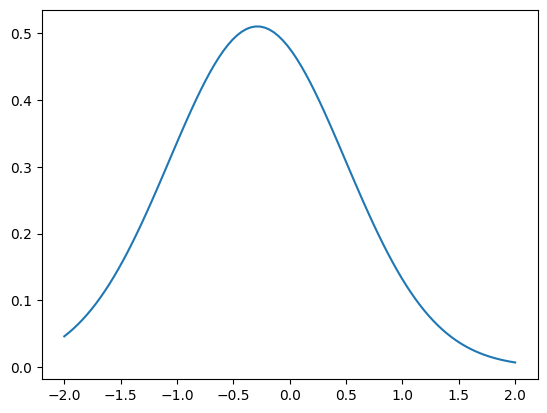

In [4]:
from parameterized_policy import ParameterizedGaussianPolicy
from utils import plot_gaussian

policy = ParameterizedGaussianPolicy(state_dim=3, action_dim=1, action_range=2)
dummy_state = [0, 0, 0]
action_mean, action_var = policy.get_action_distribution(dummy_state)
print(f"action mean: {action_mean}; action variance: {action_var}")

plot_gaussian(action_mean, action_var)

Instead of using the policy to get the action distribution, you can directly sample an action from this distribution using the *sample_action* method. Note that this method has two outputs, the first one is the sampled action, the second one we are going to ignore for now, and cover later.

In [5]:
action, _ = policy.sample_action(dummy_state)
print(action)

[-0.99625343]


We have also provided you with two utilitie functions:
 one to evaluate the policy for a given number of episodes and return the mean accumulated reward. I'ts important to average over multiple episodes because both start state and the policy is random.
 The second one will visually record the policy in the envrionment and will play it.

mean reward over 10 episodes: -964.3301467441939



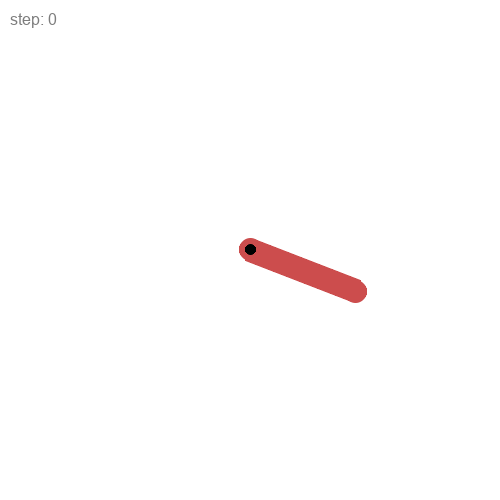

In [6]:
from utils import evaluate_agent, visualize_policy

mean_reward = evaluate_agent(policy, env, n_episodes=10)
print("mean reward over 10 episodes:", mean_reward)

visualize_policy(policy, env)

## Improving the policy
Now that we have a parameterized policy, we need to find the best parameters $\theta$ that will lead this policy to accumulate as high a reward as possible. How do we do that? possibly with gradient descent.

We would like to maximize the return. We will denote the return here with $J$. Note that it depends on the policy, thus it depends on its parameters $\theta$.

<img src="assets/return.png" style="height:100px">

If we could compute the gradient of $J$ with respect to the parameters of the policy $\theta$, we would be able to take a small step in the parameter space in the direction of the gradient, thus increasing the return and improving the policy.

#### <img src="https://em-content.zobj.net/thumbs/240/apple/354/party-popper_1f389.png" style="height:30px"> Code Time
In a neural network, the parameters are multiple matrices and vectors, but in our policy, this is abstracted and you can get all the parameters as one log vector. you can modify this vector and then change the policy parameters to the new vector:

In [7]:
theta_params = policy.get_parameters_vector()
print(f"there are {len(theta_params)} in this policy")
print(theta_params)

there are 8898 in this policy
[-0.2072573   0.537511   -0.02202576 ...  0.04491803 -0.07475954
 -0.04822883]


In [8]:
theta_params = theta_params + 0.001
policy.set_parameters_vector(theta_params)

## Policy Gradient Theorem
It Turns out (and it's not that obvious) that the gradient of the return with respect to the policy parameter can be computed.
The proof is not trivial, but the result is

<img src="assets/pg_theorem.png" style="height:80px">

In words: 
* We compute expectation over the distribution of state action pairs met in the MDP by running the policy $\pi_{\theta}$ in it (formally: the stationary distribution of the markov chain induced by the policy)
* For each state action pair, we compute the gradient of the log of the probability (according to the policy) to take that action at that state. Note that this gradient is a vector in the dimention of the parameters: we compute the gradient with respect to each parameters. This gradient can be computed since we have our $\pi$. 
* We multiply this probability by the value of that state action pair, and this is the part of the state action pair in the gradient.

Question you should ask:
* how do we compute the expectation if there are infinite number of state action pairs?
* How do we know the Q value of that state action pair?

We will see in a minute how **REINFORCE** algorithm tackels these questions.

*TODO: add proof*

#### <img src="https://em-content.zobj.net/thumbs/240/apple/354/party-popper_1f389.png" style="height:30px"> Code Time
As mentioned, we can easily compute $\nabla_{\theta} log(\pi_{\theta} (s|a)$ for any state action if we have the policy function and we do. 
Actually, it is already computed for you when you sample an action given a state. remember that policy.sample_action(state) has two outputs? well, the second one is the gradient vector $\nabla_{\theta} log(\pi_{\theta} (s|a)$ for the input state and the sampled action!

In [9]:
action, grad_log_likelihood = policy.sample_action(dummy_state)

# The grad log likelihood is a gradient vector, therefore it has the same size as theta!
print(f"gradient log likelihood size: {len(grad_log_likelihood)}")
print(grad_log_likelihood)

gradient log likelihood size: 8898
[ 0.          0.          0.         ...  0.         -0.24626589
 -0.722469  ]


## REINFORCE
![](assets/reinforce_paper.png)



Policy gradient is just a Theorem or a concept. REINFORCE, is an algorithm that uses the policy gradient theorem, along with monte carlo in order to train a parametrized policy.

Recall that we don't know the distribution of $Q^{\pi_{\theta}}(s,a)$, thus we can't compute this expectation.
In REINFORCE we approximate the expectation over the Q value of pi, with samples of returns from the environment.


*TODO: Write a more correct version in power point and add it here*
![](assets/REINFORCE.png)

## REINFORCE Implementation
add most of the algorithm, and todo to complete it

## Solving Pendulum Environment With Reinforce
Run Reinforce and plot results

## Drawback of REINFORCE
Note the oscillation in the convergence of reinforce, this happens due to the high variance in the monte carlo.
One approach to solve this, and get a better algorithm is replacing the monte carlo approximation of the return, with a value function approximate like in Q learning.
Such methods are called **Actor-Critic** methods.

*TODO: add celll that loads DDPG and trains it on pendulum, then compares it to REINFORCE with TODOS*